In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
import keras.layers as ll
from keras.models import Sequential
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

from mpl_toolkits.mplot3d import Axes3D
%pylab inline

/home/hellmetler/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


### Preproc


In [2]:
data_path = '../data/raw/'
interim_path = '../data/interim/'
result_path = '../submits/'
figures_path = '../reports/figures/'

In [3]:
train = pd.read_csv(data_path+'train.csv', index_col=0, 
                    dtype={'meter_id':str,'Timestamp':str, 'Values':np.float32})
test = pd.read_csv(data_path+'submission_format.csv',dtype={'obs_id':np.int32,'meter_id':str,
                                                            'Timestamp':str, 'is_abnormal':bool})
metadata = pd.read_csv(data_path+'metadata.csv',dtype={'site_id':str,'meter_id':str,'meter_description':str,
                                                            'units':str, 'surface':np.float32,'activity':str})
holidays =  pd.read_csv(data_path+'holidays.csv', index_col=0, 
                    dtype={'Date':str,'Holiday':str, 'site_id':str})
weather =  pd.read_csv(data_path+'weather.csv', index_col=0, 
                    dtype={'Timestamp':str,'Temperature':np.float32,'Distance':np.float32 ,'site_id':str})

train.Timestamp = pd.to_datetime(train.Timestamp)
test.Timestamp = pd.to_datetime(test.Timestamp)
holidays.Date = pd.to_datetime(holidays.Date)
weather.Timestamp = pd.to_datetime(weather.Timestamp)

/home/hellmetler/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
train = train.join(metadata.set_index('meter_id',drop = True), on = 'meter_id')

In [5]:
meter = '334_61'
site = train[train['meter_id']==meter].site_id.unique()[0]

holidays = holidays[holidays['site_id']==site]
train = train[train['site_id']==site]
weather = weather[weather['site_id']==site]
weather = weather.groupby('Timestamp',as_index= False).mean()

In [6]:
train_left = train[train['meter_id']==site]
for met_id in train['meter_id'].unique():
    if met_id != site:
        tmp = train.loc[train['meter_id']==met_id,['Timestamp','Values']].set_index('Timestamp',drop = True)
        train_left = train_left.join(tmp, on = 'Timestamp',rsuffix = '_'+met_id )
train = train_left
del train_left

In [7]:
def basic_feature_engineering(df):
    
    night_hours = {20:0,21:1,22:2,23:3,0:4,1:5,2:6,3:7,4:8,5:9,6:10}
    day_hours = dict([(h,i) for i,h in enumerate(range(7,20))])
    
    df['year'] = pd.DatetimeIndex(df['Timestamp']).year
    df['month'] = pd.DatetimeIndex(df['Timestamp']).month
    
    df['month_sin'] = np.sin(df['month']*2*pi/12)
    df['month_cos'] = np.cos(df['month']*2*pi/12)
    
    
    df['day'] = pd.DatetimeIndex(df['Timestamp']).day
        
    df['day_sin'] = np.sin(df['day']*2*pi/30)
    df['day_cos'] = np.cos(df['day']*2*pi/30)
    
    df['day_of_week'] = pd.DatetimeIndex(df['Timestamp']).weekday_name
    df['woking_day'] = (df['day_of_week']!= 'Saturday' )&(df['day_of_week']!= 'Sunday' )
    df['weekofyear'] = pd.DatetimeIndex(df['Timestamp']).weekofyear
    df['weekofyear_sin'] = np.sin(df['weekofyear']*2*pi/52)
    df['weekofyear_cos'] = np.cos(df['weekofyear']*2*pi/52)
    
    df['dayofyear'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
    df['dayofyear_sin'] = np.sin(df['dayofyear']*2*pi/365)
    df['dayofyear_cos'] = np.cos(df['dayofyear']*2*pi/365)
    
    
    df['hour'] = pd.DatetimeIndex(df['Timestamp']).hour
    
    df['hour_sin'] = np.sin(df['hour']*2*pi/24)
    df['hour_cos'] = np.cos(df['hour']*2*pi/24)
    
    df.loc[(((df['hour']>=20 )&(df['hour']<= 23 ))|((df['hour']>=0 )&(df['hour']< 7 ))),'night']= True
    df['night'].fillna(False,inplace = True)
    
    df.loc[df['night']==True,'reset_hour']= df.loc[df['night']==True,'hour'].apply(lambda x: night_hours[x] )
    df.loc[df['night']==False,'reset_hour']= df.loc[df['night']==False,'hour'].apply(lambda x: day_hours[x] )
    
    df.loc[(((df['hour']>=22 )&(df['hour']<= 23 ))|((df['hour']>=0 )&(df['hour']< 7 ))),'time_of_day']= 0
    df.loc[(((df['hour']>=7 )&(df['hour']< 10 ))|((df['hour']>=18 )&(df['hour']< 22 ))),'time_of_day']= 1
    df.loc[(((df['hour']>=10 )&(df['hour']< 18 ))),'time_of_day']= 2
    
    df['minute'] = pd.DatetimeIndex(df['Timestamp']).minute
    return df

In [8]:
train = basic_feature_engineering(train)

In [9]:
train.dropna(subset = ['Values'], inplace = True)

In [10]:
weather['year'] = pd.DatetimeIndex(weather['Timestamp']).year
weather['month'] = pd.DatetimeIndex(weather['Timestamp']).month
weather['day'] = pd.DatetimeIndex(weather['Timestamp']).day
weather['hour'] = pd.DatetimeIndex(weather['Timestamp']).hour
weather = weather.groupby(['year','month','day','hour'], as_index = False).mean()

In [11]:
train = pd.merge(train,weather[['year','month','day','hour','Temperature']], how='left', 
                 on = ['year','month','day','hour'])

In [12]:
train = train.join(train[['year','month','day','Temperature']].groupby(['year','month','day']).mean(),
           on = ['year','month','day'],rsuffix = '_mean_date')

In [13]:
train['Temperature_sq']=train['Temperature']**2

In [14]:
train['night'] = train['night'].astype(int)
train = train.join(train[['year','month','day','night','Temperature']].groupby(['year','month','day','night']).mean(),
           on = ['year','month','day','night'],rsuffix = '_mean_time_of_day')

In [15]:
holidays['year'] = pd.DatetimeIndex(holidays['Date']).year
holidays['month'] = pd.DatetimeIndex(holidays['Date']).month
holidays['day'] = pd.DatetimeIndex(holidays['Date']).day
holidays['is_holiday'] = True
holidays.drop_duplicates(subset = ['Date'], inplace = True)

In [16]:
train = train.join(holidays[['year','month','day','is_holiday']].set_index(['year','month','day']),
                   on = ['year','month','day'])

In [17]:
train.is_holiday.fillna(False, inplace = True)
train['is_holiday'] = train['is_holiday'].astype(int)

In [18]:
train['is_abnormal'] = False

In [19]:
train['high_temp'] =train ['Temperature_mean_date']>17
train.loc[(train.Timestamp>'2015-08-09')&(train.Timestamp<'2015-08-15'),'is_holiday']= True
train.loc[((train['woking_day']==True)&(train['high_temp']==True)&(train['is_holiday']==False)),'model_num'] = 1
train.loc[((train['woking_day']==True)&(train['high_temp']==False)&(train['is_holiday']==False)),'model_num'] = 2
train.loc[((train['woking_day']==False)&(train['high_temp']==False)&(train['is_holiday']==False)),'model_num'] = 3
train.loc[((train['woking_day']==False)&(train['high_temp']==True)&(train['is_holiday']==False)),'model_num'] = 4
train ['model_num'].fillna(0,inplace = True)


In [20]:
scaler = StandardScaler()

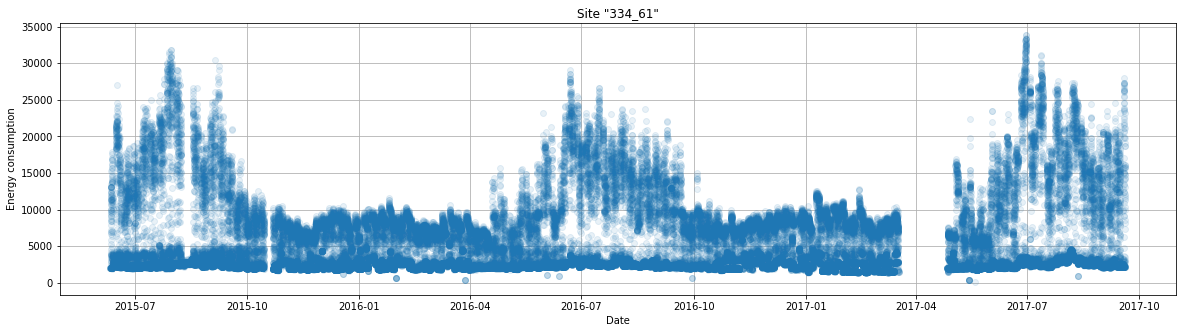

In [21]:
plt.figure(figsize=(20,5))
plt.plot(train['Timestamp'],train['Values'],'o',alpha = 0.1)

plt.title('Site "334_61"')
plt.xlabel('Date')
plt.ylabel('Energy consumption')
plt.grid(True)
savefig(figures_path+'1a.jpg')

### modelling

In [22]:
cols = ['dayofyear','weekofyear','woking_day', 'weekofyear_sin', 'weekofyear_cos','dayofyear_sin','dayofyear_cos', 'hour_sin', 
        'hour_cos', 'night','Temperature', 'Temperature_sq','Temperature_mean_date','Temperature_mean_time_of_day','Values']

x_cols = ['Temperature_mean_time_of_day','Temperature_mean_date','dayofyear_sin','dayofyear_cos','Temperature',
        'hour_sin', 'hour_cos']

scale_cols = ['Temperature_mean_time_of_day','Temperature_mean_date','Temperature']

#### working day_high temp

In [24]:
train_1 = train.loc[(train['model_num']==1)].copy()

In [25]:
##knn
model = KNeighborsRegressor(n_neighbors=1000,p=1, n_jobs=-1)
scaler = StandardScaler()

x_train = train_1.dropna(subset = x_cols)[x_cols]
x_train.loc[:,scale_cols] = scaler.fit_transform(x_train[scale_cols].values)
y_train = train_1.dropna(subset = x_cols)['Values']

model.fit(x_train,y_train)
y_pred = model.predict(x_train)
(mean_absolute_error(y_train,y_pred))

1512.4327

In [26]:
train_1.loc[x_train.index,'Values_pred_2'] = y_pred
train_1['error_2'] = (train_1['Values']-train_1['Values_pred_2'])
train_1['metric_2'] = np.abs(train_1['error_2']-train_1['error_2'].mean())/(train_1['error_2'].std())

In [27]:
threshold = 4.5
train_1['is_abnormal_2']=train_1['metric_2']>threshold
train_1['is_abnormal_2'].fillna(False,inplace = True)

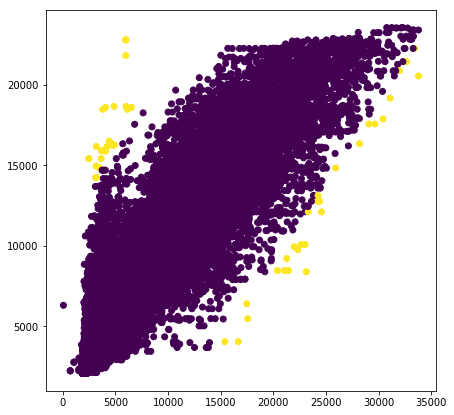

In [28]:
plt.figure(figsize=(7,7))
plt.scatter(train_1.Values,train_1.Values_pred_2,c = train_1.is_abnormal_2)


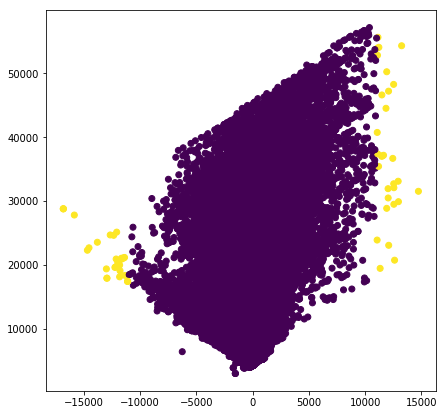

In [29]:
plt.figure(figsize=(7,7))
plt.scatter(train_1.Values-train_1.Values_pred_2,train_1.Values+train_1.Values_pred_2,c = train_1.is_abnormal_2)

In [30]:
## nn 

In [31]:
x_df = train_1[['Values','Temperature','hour']].dropna()

In [32]:
scaler = StandardScaler()
X = scaler.fit_transform(x_df[['Temperature','hour']])

In [33]:
model = Sequential()
model.add(ll.InputLayer(input_shape=[X.shape[1],]))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1))
model.compile('adam',loss='mae')

In [34]:
model.fit(X,x_df['Values'],epochs=10,batch_size=64)

Epoch 1/10
31405/31405 [==============================] - 31s 975us/step - loss: 2179.7728
Epoch 2/10
31405/31405 [==============================] - 30s 961us/step - loss: 1688.5963
Epoch 3/10
31405/31405 [==============================] - 29s 911us/step - loss: 1657.4657
Epoch 4/10
31405/31405 [==============================] - 29s 921us/step - loss: 1626.5449
Epoch 5/10
31405/31405 [==============================] - 29s 908us/step - loss: 1602.5837
Epoch 6/10
31405/31405 [==============================] - 28s 901us/step - loss: 1584.1905
Epoch 7/10
31405/31405 [==============================] - 29s 913us/step - loss: 1591.5861
Epoch 8/10
31405/31405 [==============================] - 29s 933us/step - loss: 1578.7075
Epoch 9/10
31405/31405 [==============================] - 30s 966us/step - loss: 1583.2704
Epoch 10/10
31405/31405 [==============================] - 31s 978us/step - loss: 1585.4938


In [35]:
y_pred = model.predict(X)

In [36]:
x = np.linspace(17,40,24)
y = np.linspace(0,23,24)

In [37]:
xx = scaler.fit(x_df['Temperature'].values.reshape(-1, 1)).transform(x.reshape(-1, 1))
yy = scaler.fit(x_df['hour'].values.reshape(-1, 1)).transform(y.reshape(-1, 1))

/home/hellmetler/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [38]:
xx,yy = np.meshgrid(xx,yy)

In [39]:
vals = []
for i,t in enumerate(xx):
    vals.append(model.predict(np.hstack((t.reshape(-1,1),yy[i].reshape(-1,1)))).reshape(1,-1))
        

In [40]:
vals = np.array(vals)

In [41]:
x,y = np.meshgrid(x,y)

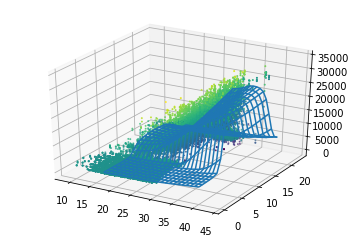

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe( x,y,vals.squeeze())
ax.scatter( x_df['Temperature'],x_df['hour'],x_df['Values'], 
           c = (x_df['Values'].values-y_pred.reshape(1,-1)).squeeze(),s=1)

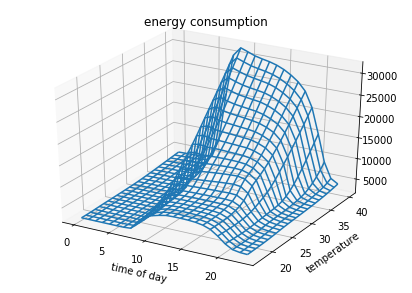

In [43]:
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe( y,x,vals.squeeze())
plt.xlabel('time of day')
plt.ylabel('temperature')
plt.title('energy consumption')

savefig(figures_path+'fig2_mod_1')
#ax.scatter( x_df['hour'],x_df['Temperature'],x_df['Values'], 
#           c = (x_df['Values'].values-y_pred.reshape(1,-1)).squeeze(),s=1)

In [44]:
train_1.loc[x_df.index,'Values_pred_1'] = y_pred

In [45]:
train_1['error_1'] = (train_1['Values']-train_1['Values_pred_1'])
train_1['metric_1'] = np.abs(train_1['error_1']-train_1['error_1'].mean())/(train_1['error_1'].std())

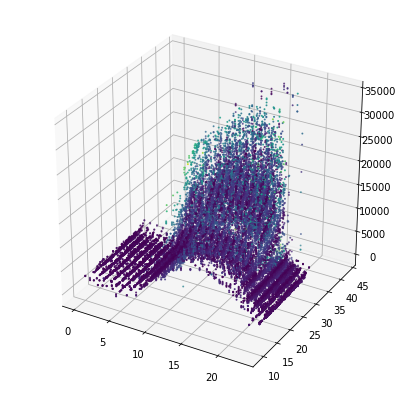

In [46]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter( train_1['hour'],train_1['Temperature'],train_1['Values'], 
           c = train_1['metric_1'],s=1)

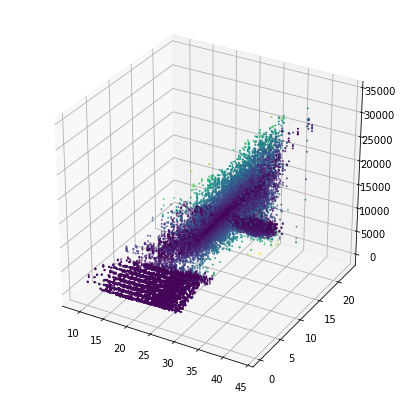

In [47]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter( train_1['Temperature'],train_1['hour'],train_1['Values'], 
           c = train_1['metric_1'],s=1)


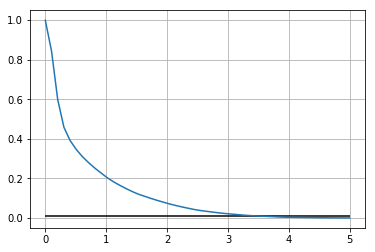

In [48]:
thresholds = np.linspace(0,5,50)
n_anoms = []
for thresh in thresholds:
    n_anoms.append((train_1['metric_1']>thresh).sum()/len(train_1))
    
    
    
plt.plot(thresholds,n_anoms)
plt.hlines(0.01,thresholds.min(),thresholds.max())

plt.grid(True)

In [49]:
threshold = 4.5
train_1['is_abnormal_1']=train_1['metric_1']>threshold
train_1['is_abnormal_1'].fillna(False,inplace = True)

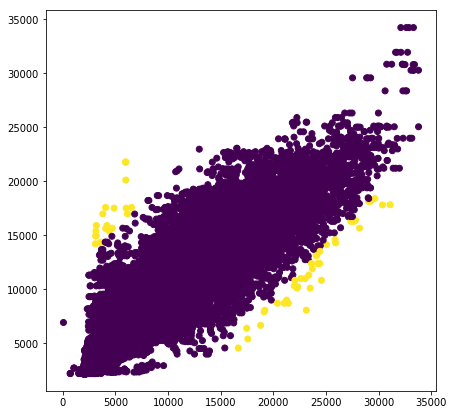

In [50]:
plt.figure(figsize=(7,7))
plt.scatter(train_1.Values,train_1.Values_pred_1,c = train_1.is_abnormal_1)


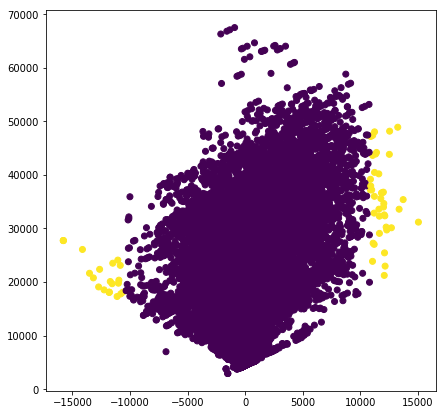

In [51]:
plt.figure(figsize=(7,7))
plt.scatter(train_1.Values-train_1.Values_pred_1,train_1.Values+train_1.Values_pred_1,c = train_1.is_abnormal_1)

In [52]:
train.loc[train_1.index,'is_abnormal_1'] = train_1['is_abnormal_1']
train.loc[train_1.index,'Values_pred_1'] = train_1['Values_pred_1']
train.loc[train_1.index,'metric_1'] = train_1['metric_1']

train.loc[train_1.index,'is_abnormal_2'] = train_1['is_abnormal_2']
train.loc[train_1.index,'Values_pred_2'] = train_1['Values_pred_2']
train.loc[train_1.index,'metric_2'] = train_1['metric_2']

#### working day_low temp

In [54]:
train_1 = train.loc[(train['model_num']==2)].copy()

In [55]:
##knn
model = KNeighborsRegressor(n_neighbors=1000,p=1, n_jobs=-1)
scaler = StandardScaler()

x_train = train_1.dropna(subset = x_cols)[x_cols]
x_train.loc[:,scale_cols] = scaler.fit_transform(x_train[scale_cols].values)
y_train = train_1.dropna(subset = x_cols)['Values']

model.fit(x_train,y_train)
y_pred = model.predict(x_train)
(mean_absolute_error(y_train,y_pred))

747.05688

In [56]:
train_1.loc[x_train.index,'Values_pred_2'] = y_pred
train_1['error_2'] = (train_1['Values']-train_1['Values_pred_2'])
train_1['metric_2'] = np.abs(train_1['error_2']-train_1['error_2'].mean())/(train_1['error_2'].std())

threshold = 3.
train_1['is_abnormal_2']=train_1['metric_2']>threshold
train_1['is_abnormal_2'].fillna(False,inplace = True)

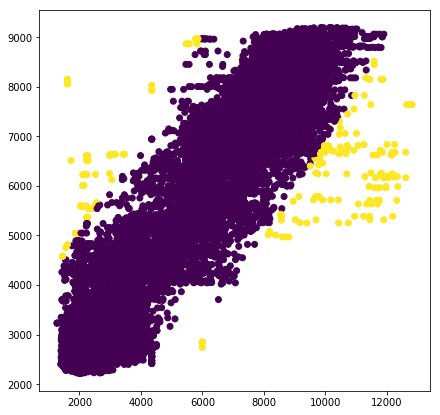

In [57]:
plt.figure(figsize=(7,7))
plt.scatter(train_1.Values,train_1.Values_pred_2,c = train_1.is_abnormal_2)


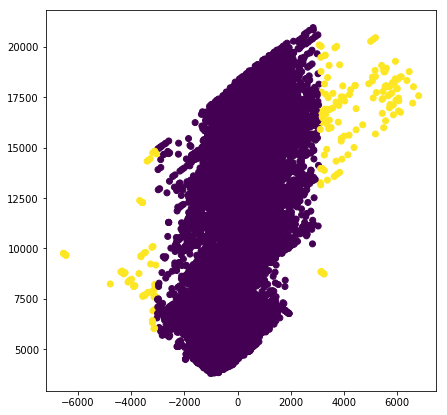

In [58]:
plt.figure(figsize=(7,7))
plt.scatter(train_1.Values-train_1.Values_pred_2,train_1.Values+train_1.Values_pred_2,c = train_1.is_abnormal_2)

In [59]:
x_df = train_1[['Values','Temperature','hour']].dropna()

In [60]:
scaler = StandardScaler()
X = scaler.fit_transform(x_df[['Temperature','hour']])

In [61]:
model = Sequential()
model.add(ll.InputLayer(input_shape=[X.shape[1],]))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))


model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1))
model.compile('adam',loss='mae')

In [62]:
model.fit(X,x_df['Values'],epochs=10,batch_size=64)

Epoch 1/10
19958/19958 [==============================] - 20s 982us/step - loss: 1631.1058
Epoch 2/10
19958/19958 [==============================] - 19s 966us/step - loss: 922.8352
Epoch 3/10
19958/19958 [==============================] - 20s 978us/step - loss: 863.4085
Epoch 4/10
19958/19958 [==============================] - 19s 973us/step - loss: 860.8349
Epoch 5/10
19958/19958 [==============================] - 19s 976us/step - loss: 836.9115
Epoch 6/10
19958/19958 [==============================] - 20s 987us/step - loss: 823.7584
Epoch 7/10
19958/19958 [==============================] - 20s 1ms/step - loss: 819.7783
Epoch 8/10
19958/19958 [==============================] - 19s 964us/step - loss: 809.9370
Epoch 9/10
19958/19958 [==============================] - 19s 968us/step - loss: 794.0486
Epoch 10/10
19958/19958 [==============================] - 19s 962us/step - loss: 786.7121


In [63]:
y_pred = model.predict(X)

In [64]:
x = np.linspace(0,17,18)
y = np.linspace(0,23,24)

In [65]:
xx = scaler.fit(x_df['Temperature'].values.reshape(-1, 1)).transform(x.reshape(-1, 1))
yy = scaler.fit(x_df['hour'].values.reshape(-1, 1)).transform(y.reshape(-1, 1))

/home/hellmetler/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [66]:
xx,yy = np.meshgrid(xx,yy)

In [67]:
vals = []
for i,t in enumerate(xx):
    vals.append(model.predict(np.hstack((t.reshape(-1,1),yy[i].reshape(-1,1)))).reshape(1,-1))
        

In [68]:
vals = np.array(vals)

In [69]:
x,y = np.meshgrid(x,y)

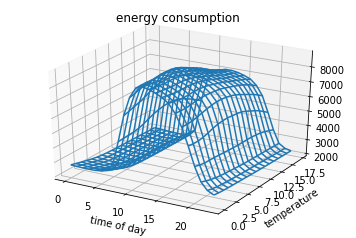

In [70]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_wireframe( y,x,vals.squeeze())
#ax.scatter( x_df['hour'],x_df['Temperature'],x_df['Values'], 
#           c = (x_df['Values'].values-y_pred.reshape(1,-1)).squeeze(),s=1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe( y,x,vals.squeeze())
plt.xlabel('time of day')
plt.ylabel('temperature')
plt.title('energy consumption')

savefig(figures_path+'fig2_mod_2')

In [71]:
train_1.loc[x_df.index,'Values_pred_1'] = y_pred
train_1['error_1'] = (train_1['Values']-train_1['Values_pred_1'])
train_1['metric_1'] = np.abs(train_1['error_1']-train_1['error_1'].mean())/train_1['error_1'].std()

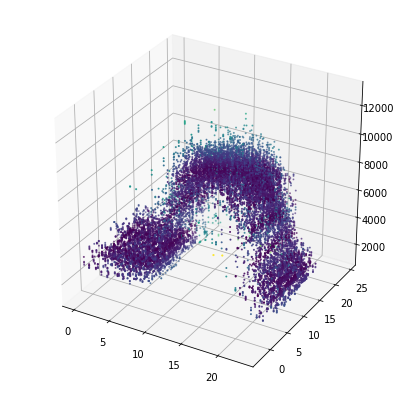

In [72]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter( train_1['hour'],train_1['Temperature'],train_1['Values'], 
           c = train_1['metric_1'],s=1)

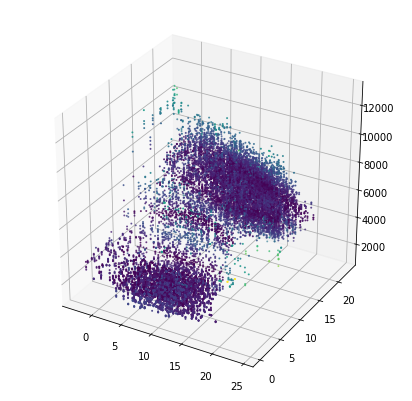

In [73]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter( train_1['Temperature'],train_1['hour'],train_1['Values'], 
           c = train_1['metric_1'],s=1)


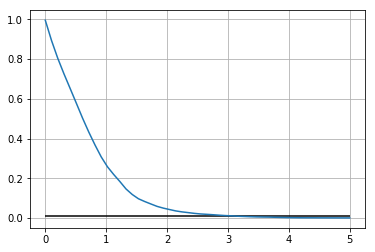

In [74]:
thresholds = np.linspace(0.,5,50)
n_anoms = []
for thresh in thresholds:
    n_anoms.append((train_1['metric_1']>thresh).sum()/len(train_1))
    
    
    
plt.plot(thresholds,n_anoms)
plt.hlines(0.01,thresholds.min(),thresholds.max())

plt.grid(True)

In [75]:
threshold = 4.
train_1['is_abnormal_1']=train_1['metric_1']>threshold
train_1['is_abnormal_1'].fillna(False,inplace = True)

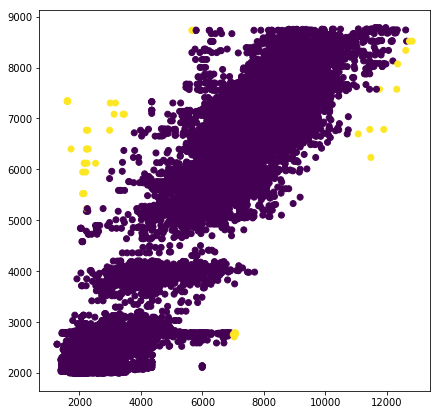

In [76]:
plt.figure(figsize=(7,7))
plt.scatter(train_1.Values,train_1.Values_pred_1,c = train_1.is_abnormal_1)


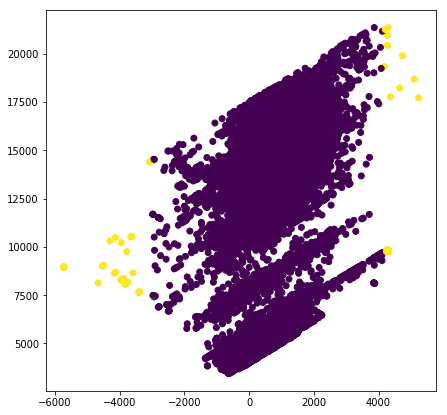

In [77]:
plt.figure(figsize=(7,7))
plt.scatter(train_1.Values-train_1.Values_pred_1,train_1.Values+train_1.Values_pred_1,c = train_1.is_abnormal_1)

In [78]:
train_1.is_abnormal_1.sum()

46

In [79]:
train_1.is_abnormal_2.sum()

197

In [80]:
(train_1.is_abnormal_1&train_1.is_abnormal_2).sum()

38

In [81]:
train.loc[train_1.index,'is_abnormal_1'] = train_1['is_abnormal_1']
train.loc[train_1.index,'Values_pred_1'] = train_1['Values_pred_1']
train.loc[train_1.index,'metric_1'] = train_1['metric_1']

train.loc[train_1.index,'is_abnormal_2'] = train_1['is_abnormal_2']
train.loc[train_1.index,'Values_pred_2'] = train_1['Values_pred_2']
train.loc[train_1.index,'metric_2'] = train_1['metric_2']

#### weekend_low temp

In [83]:
train_1 = train.loc[(train['model_num']==3)].copy()

In [84]:
##knn
model = KNeighborsRegressor(n_neighbors=1000,p=1, n_jobs=-1)
scaler = StandardScaler()

x_train = train_1.dropna(subset = x_cols)[x_cols]
x_train.loc[:,scale_cols] = scaler.fit_transform(x_train[scale_cols].values)
y_train = train_1.dropna(subset = x_cols)['Values']

model.fit(x_train,y_train)
y_pred = model.predict(x_train)
(mean_absolute_error(y_train,y_pred))

401.82816

In [85]:
train_1.loc[x_train.index,'Values_pred_2'] = y_pred
train_1['error_2'] = (train_1['Values']-train_1['Values_pred_2'])
train_1['metric_2'] = np.abs(train_1['error_2']-train_1['error_2'].mean())/(train_1['error_2'].std())

threshold = 3.
train_1['is_abnormal_2']=train_1['metric_2']>threshold
train_1['is_abnormal_2'].fillna(False,inplace = True)

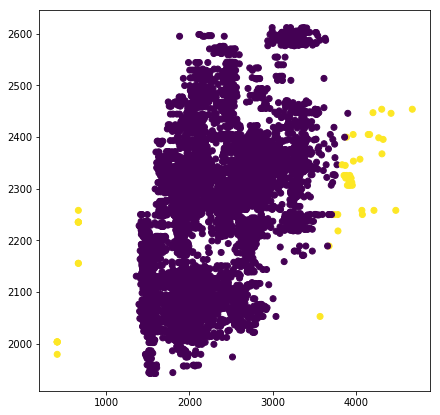

In [86]:
plt.figure(figsize=(7,7))
plt.scatter(train_1.Values,train_1.Values_pred_2,c = train_1.is_abnormal_2)


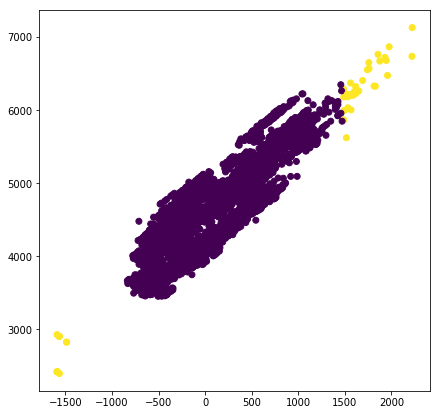

In [87]:
plt.figure(figsize=(7,7))
plt.scatter(train_1.Values-train_1.Values_pred_2,train_1.Values+train_1.Values_pred_2,c = train_1.is_abnormal_2)

In [88]:
x_df = train_1[['Values','Temperature','hour']].dropna()

In [89]:
scaler = StandardScaler()
X = scaler.fit_transform(x_df[['Temperature','hour']])

In [90]:
model = Sequential()
model.add(ll.InputLayer(input_shape=[X.shape[1],]))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1))
model.compile('adam',loss='mae')

In [91]:
model.fit(X,x_df['Values'],epochs=10,batch_size=64)

Epoch 1/10
7955/7955 [==============================] - 8s 967us/step - loss: 726.0361
Epoch 2/10
7955/7955 [==============================] - 8s 968us/step - loss: 475.1866
Epoch 3/10
7955/7955 [==============================] - 8s 961us/step - loss: 469.1762
Epoch 4/10
7955/7955 [==============================] - 8s 959us/step - loss: 483.7162
Epoch 5/10
7955/7955 [==============================] - 8s 962us/step - loss: 472.4129
Epoch 6/10
7955/7955 [==============================] - 8s 975us/step - loss: 467.5676
Epoch 7/10
7955/7955 [==============================] - 8s 966us/step - loss: 468.3629
Epoch 8/10
7955/7955 [==============================] - 8s 962us/step - loss: 472.0802
Epoch 9/10
7955/7955 [==============================] - 8s 963us/step - loss: 467.4022
Epoch 10/10
7955/7955 [==============================] - 8s 964us/step - loss: 465.4744


In [92]:
y_pred = model.predict(X)

In [93]:
x = np.linspace(0,17,18)
y = np.linspace(0,23,24)

In [94]:
xx = scaler.fit(x_df['Temperature'].values.reshape(-1, 1)).transform(x.reshape(-1, 1))
yy = scaler.fit(x_df['hour'].values.reshape(-1, 1)).transform(y.reshape(-1, 1))

/home/hellmetler/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [95]:
xx,yy = np.meshgrid(xx,yy)

In [96]:
vals = []
for i,t in enumerate(xx):
    vals.append(model.predict(np.hstack((t.reshape(-1,1),yy[i].reshape(-1,1)))).reshape(1,-1))
        

In [97]:
vals = np.array(vals)

In [98]:
x,y = np.meshgrid(x,y)

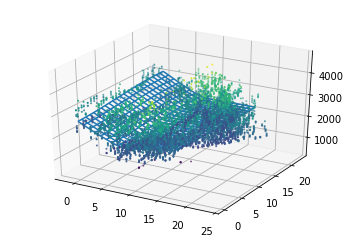

In [99]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe( x,y,vals.squeeze())
ax.scatter( x_df['Temperature'],x_df['hour'],x_df['Values'], 
           c = (x_df['Values'].values-y_pred.reshape(1,-1)).squeeze(),s=1)

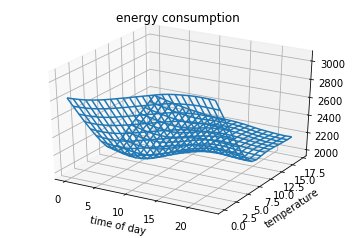

In [100]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_wireframe( y,x,vals.squeeze())
#ax.scatter( x_df['hour'],x_df['Temperature'],x_df['Values'], 
#           c = (x_df['Values'].values-y_pred.reshape(1,-1)).squeeze(),s=1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe( y,x,vals.squeeze())
plt.xlabel('time of day')
plt.ylabel('temperature')
plt.title('energy consumption')

savefig(figures_path+'fig2_mod_3')

In [101]:
train_1.loc[x_df.index,'Values_pred_1'] = y_pred

In [102]:
train_1['error_1'] = (train_1['Values']-train_1['Values_pred_1'])

In [103]:
train_1['metric_1'] = np.abs(train_1['error_1']-train_1['error_1'].mean())/train_1['error_1'].std()

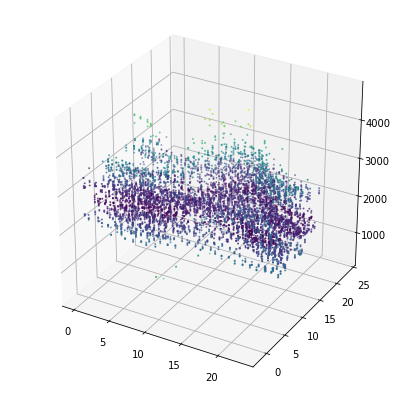

In [104]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter( train_1['hour'],train_1['Temperature'],train_1['Values'], 
           c = train_1['metric_1'],s=1)

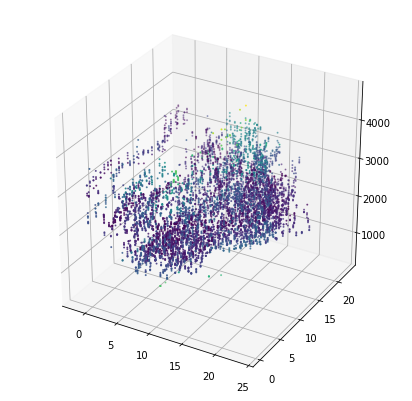

In [105]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter( train_1['Temperature'],train_1['hour'],train_1['Values'], 
           c = train_1['metric_1'],s=1)


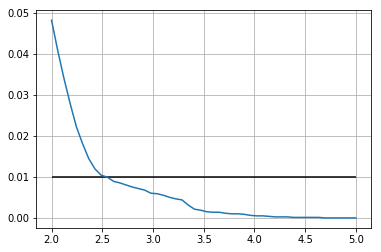

In [106]:
thresholds = np.linspace(2.,5,50)
n_anoms = []
for thresh in thresholds:
    n_anoms.append((train_1['metric_1']>thresh).sum()/len(train_1))
    
    
    
plt.plot(thresholds,n_anoms)
plt.hlines(0.01,thresholds.min(),thresholds.max())

plt.grid(True)

In [107]:
threshold = 2.5
train_1['is_abnormal_1']=train_1['metric_1']>threshold
train_1['is_abnormal_1'].fillna(False,inplace = True)

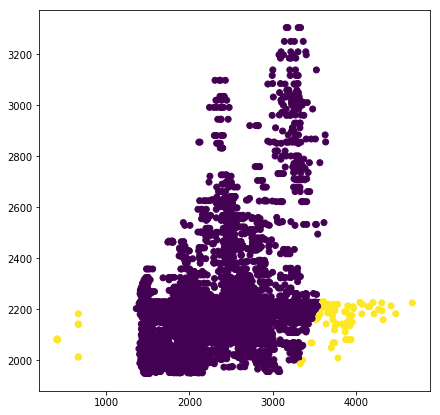

In [108]:
plt.figure(figsize=(7,7))
plt.scatter(train_1.Values,train_1.Values_pred_1,c = train_1.is_abnormal_1)


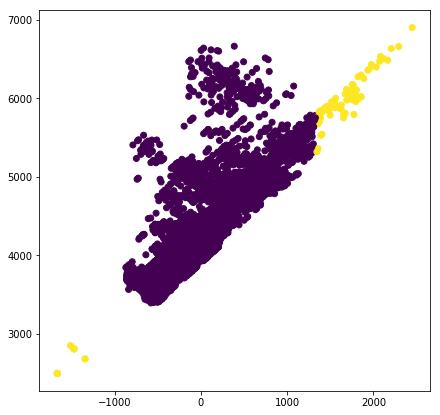

In [109]:
plt.figure(figsize=(7,7))
plt.scatter(train_1.Values-train_1.Values_pred_1,train_1.Values+train_1.Values_pred_1,c = train_1.is_abnormal_1)

In [110]:
train_1.is_abnormal_1.sum()

83

In [111]:
train_1.is_abnormal_2.sum()

50

In [112]:
(train_1.is_abnormal_1&train_1.is_abnormal_2).sum()

50

In [113]:
train.loc[train_1.index,'is_abnormal_1'] = train_1['is_abnormal_1']
train.loc[train_1.index,'Values_pred_1'] = train_1['Values_pred_1']
train.loc[train_1.index,'metric_1'] = train_1['metric_1']

train.loc[train_1.index,'is_abnormal_2'] = train_1['is_abnormal_2']
train.loc[train_1.index,'Values_pred_2'] = train_1['Values_pred_2']
train.loc[train_1.index,'metric_2'] = train_1['metric_2']

#### woeekend_high temp

In [115]:
train_1 = train.loc[(train['model_num']==4)].copy()

In [116]:
##knn
model = KNeighborsRegressor(n_neighbors=1000,p=1, n_jobs=-1)
scaler = StandardScaler()

x_train = train_1.dropna(subset = x_cols)[x_cols]
x_train.loc[:,scale_cols] = scaler.fit_transform(x_train[scale_cols].values)
y_train = train_1.dropna(subset = x_cols)['Values']

model.fit(x_train,y_train)
y_pred = model.predict(x_train)
(mean_absolute_error(y_train,y_pred))

230.74051

In [117]:
train_1.loc[x_train.index,'Values_pred_2'] = y_pred
train_1['error_2'] = (train_1['Values']-train_1['Values_pred_2'])
train_1['metric_2'] = np.abs(train_1['error_2']-train_1['error_2'].mean())/(train_1['error_2'].std())

threshold = 2.
train_1['is_abnormal_2']=train_1['metric_2']>threshold
train_1['is_abnormal_2'].fillna(False,inplace = True)

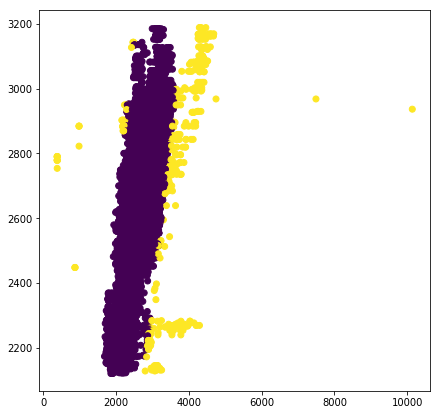

In [118]:
plt.figure(figsize=(7,7))
plt.scatter(train_1.Values,train_1.Values_pred_2,c = train_1.is_abnormal_2)


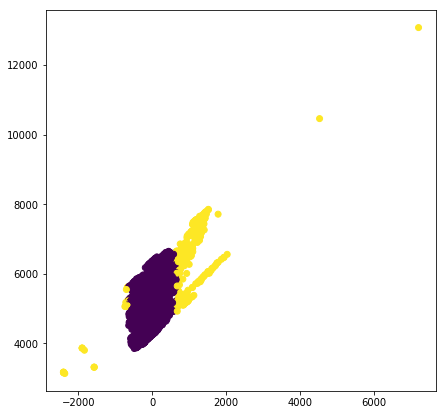

In [119]:
plt.figure(figsize=(7,7))
plt.scatter(train_1.Values-train_1.Values_pred_2,train_1.Values+train_1.Values_pred_2,c = train_1.is_abnormal_2)

In [120]:
x_df = train_1[['Values','Temperature','hour']].dropna()

In [121]:
scaler = StandardScaler()
X = scaler.fit_transform(x_df[['Temperature','hour']])

In [122]:
model = Sequential()
model.add(ll.InputLayer(input_shape=[X.shape[1],]))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1))
model.compile('adam',loss='mae')

In [123]:
model.fit(X,x_df['Values'],epochs=10,batch_size=64)

Epoch 1/10
12749/12749 [==============================] - 12s 980us/step - loss: 536.7723
Epoch 2/10
12749/12749 [==============================] - 12s 979us/step - loss: 342.5619
Epoch 3/10
12749/12749 [==============================] - 12s 960us/step - loss: 349.4461
Epoch 4/10
12749/12749 [==============================] - 12s 962us/step - loss: 335.8754
Epoch 5/10
12749/12749 [==============================] - 12s 965us/step - loss: 340.5502
Epoch 6/10
12749/12749 [==============================] - 12s 964us/step - loss: 342.9031
Epoch 7/10
12749/12749 [==============================] - 12s 969us/step - loss: 331.7330
Epoch 8/10
12749/12749 [==============================] - 12s 977us/step - loss: 329.0120
Epoch 9/10
12749/12749 [==============================] - 13s 1ms/step - loss: 327.0874
Epoch 10/10
12749/12749 [==============================] - 13s 984us/step - loss: 327.9595


In [124]:
y_pred = model.predict(X)

In [125]:
x = np.linspace(17,40,24)
y = np.linspace(0,23,24)

In [126]:
xx = scaler.fit(x_df['Temperature'].values.reshape(-1, 1)).transform(x.reshape(-1, 1))
yy = scaler.fit(x_df['hour'].values.reshape(-1, 1)).transform(y.reshape(-1, 1))

/home/hellmetler/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [127]:
xx,yy = np.meshgrid(xx,yy)

In [128]:
vals = []
for i,t in enumerate(xx):
    vals.append(model.predict(np.hstack((t.reshape(-1,1),yy[i].reshape(-1,1)))).reshape(1,-1))
        

In [129]:
vals = np.array(vals)

In [130]:
x,y = np.meshgrid(x,y)

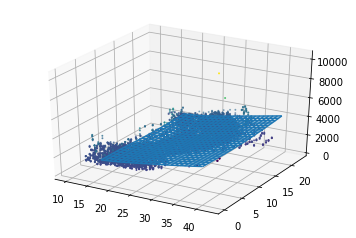

In [131]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe( x,y,vals.squeeze())
ax.scatter( x_df['Temperature'],x_df['hour'],x_df['Values'], 
           c = (x_df['Values'].values-y_pred.reshape(1,-1)).squeeze(),s=1)

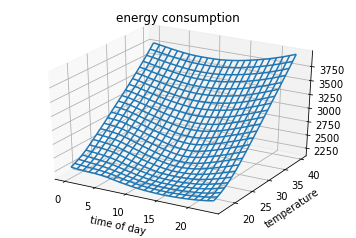

In [132]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_wireframe( y,x,vals.squeeze())
#ax.scatter( x_df['hour'],x_df['Temperature'],x_df['Values'], 
#           c = (x_df['Values'].values-y_pred.reshape(1,-1)).squeeze(),s=1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe( y,x,vals.squeeze())
plt.xlabel('time of day')
plt.ylabel('temperature')
plt.title('energy consumption')

savefig(figures_path+'fig2_mod_4')

In [133]:
train_1.loc[x_df.index,'Values_pred_1'] = y_pred

In [134]:
train_1['error_1'] = (train_1['Values']-train_1['Values_pred_1'])

In [135]:
train_1['metric_1'] = np.abs(train_1['error_1']-train_1['error_1'].mean())/train_1['error_1'].std()

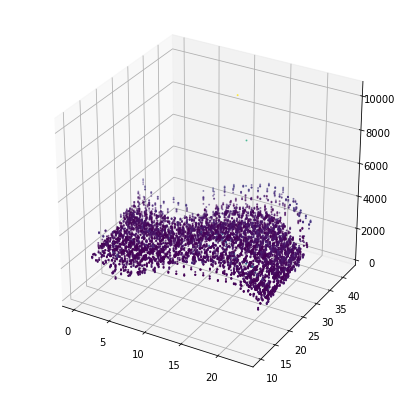

In [136]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter( train_1['hour'],train_1['Temperature'],train_1['Values'], 
           c = train_1['metric_1'],s=1)

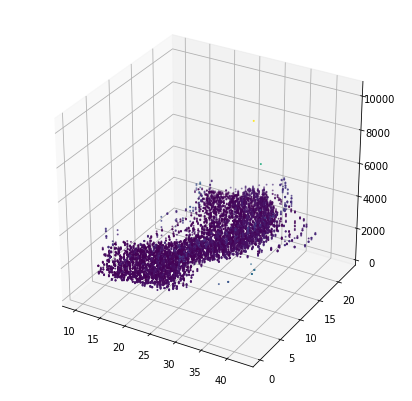

In [137]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter( train_1['Temperature'],train_1['hour'],train_1['Values'], 
           c = train_1['metric_1'],s=1)


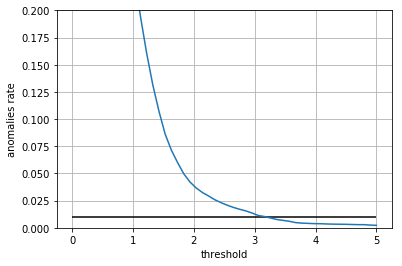

In [138]:
thresholds = np.linspace(0.,5,50)
n_anoms = []
for thresh in thresholds:
    n_anoms.append((train_1['metric_1']>thresh).sum()/len(train_1))
    
    
    
plt.plot(thresholds,n_anoms)
plt.hlines(0.01,thresholds.min(),thresholds.max())

plt.xlabel('threshold')
plt.ylabel('anomalies rate')
plt.ylim(0,0.2)
plt.grid(True)

savefig(figures_path+'fig3')

In [139]:
threshold = 2.0
train_1['is_abnormal_1']=train_1['metric_1']>threshold
train_1['is_abnormal_1'].fillna(False,inplace = True)

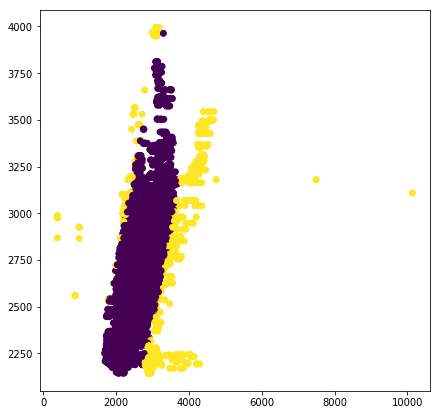

In [140]:
plt.figure(figsize=(7,7))
plt.scatter(train_1.Values,train_1.Values_pred_1,c = train_1.is_abnormal_1)


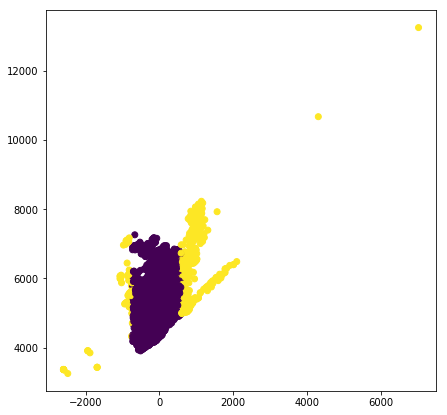

In [141]:
plt.figure(figsize=(7,7))
plt.scatter(train_1.Values-train_1.Values_pred_1,train_1.Values+train_1.Values_pred_1,c = train_1.is_abnormal_1)

In [142]:
train_1.is_abnormal_1.sum()

496

In [143]:
train_1.is_abnormal_2.sum()

408

In [144]:
(train_1.is_abnormal_1&train_1.is_abnormal_2).sum()

378

In [145]:
train.loc[train_1.index,'is_abnormal_1'] = train_1['is_abnormal_1']
train.loc[train_1.index,'Values_pred_1'] = train_1['Values_pred_1']
train.loc[train_1.index,'metric_1'] = train_1['metric_1']

train.loc[train_1.index,'is_abnormal_2'] = train_1['is_abnormal_2']
train.loc[train_1.index,'Values_pred_2'] = train_1['Values_pred_2']
train.loc[train_1.index,'metric_2'] = train_1['metric_2']

### change thresholds

In [146]:
thresholds_nn = [4.2,4,2.5,2]
thresholds_knn = [4.5,3,3.,2.]


In [147]:
train.loc[train['model_num']==1,'is_abnormal_1']=train[(train['model_num']==1)]['metric_1']>thresholds_nn[0]
train.loc[train['model_num']==2,'is_abnormal_1']=train[(train['model_num']==2)]['metric_1']>thresholds_nn[1]
train.loc[train['model_num']==3,'is_abnormal_1']=train[(train['model_num']==3)]['metric_1']>thresholds_nn[2]
train.loc[train['model_num']==4,'is_abnormal_1']=train[(train['model_num']==4)]['metric_1']>thresholds_nn[3]

train.loc[train['model_num']==1,'is_abnormal_2']=train[(train['model_num']==1)]['metric_2']>thresholds_knn[0]
train.loc[train['model_num']==2,'is_abnormal_2']=train[(train['model_num']==2)]['metric_2']>thresholds_knn[1]
train.loc[train['model_num']==3,'is_abnormal_2']=train[(train['model_num']==3)]['metric_2']>thresholds_knn[2]
train.loc[train['model_num']==4,'is_abnormal_2']=train[(train['model_num']==4)]['metric_2']>thresholds_knn[3]

In [148]:
train.is_abnormal_1.sum()

735

In [149]:
train.is_abnormal_2.sum()

716

In [150]:
(train.is_abnormal_1&train.is_abnormal_2).sum()

511

In [151]:
train.is_abnormal = (train.is_abnormal_1&train.is_abnormal_2)

In [152]:
train.is_abnormal.sum()

511

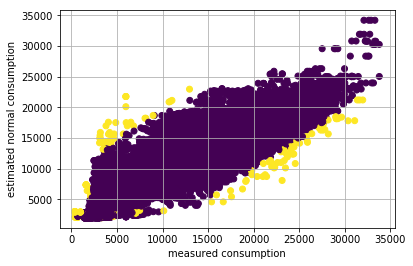

In [153]:
#plt.figure(figsize=(7,7))
plt.scatter(train.drop(train[train.Values < 100].index).Values,train.drop(train[train.Values < 100].index
                                            ).Values_pred_1, c = train.drop(train[train.Values < 100].index
                                                                                        ).is_abnormal_1)
plt.xlabel('measured consumption')
plt.ylabel('estimated normal consumption')
plt.grid(True)
savefig(figures_path+'fig4')


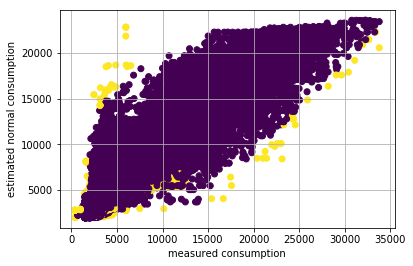

In [154]:
#plt.figure(figsize=(7,7))
plt.scatter(train.drop(train[train.Values < 100].index).Values,train.drop(train[train.Values < 100].index
                                            ).Values_pred_2, c = train.drop(train[train.Values < 100].index
                                                                                        ).is_abnormal_2)
plt.xlabel('measured consumption')
plt.ylabel('estimated normal consumption')
plt.grid(True)
savefig(figures_path+'fig5')


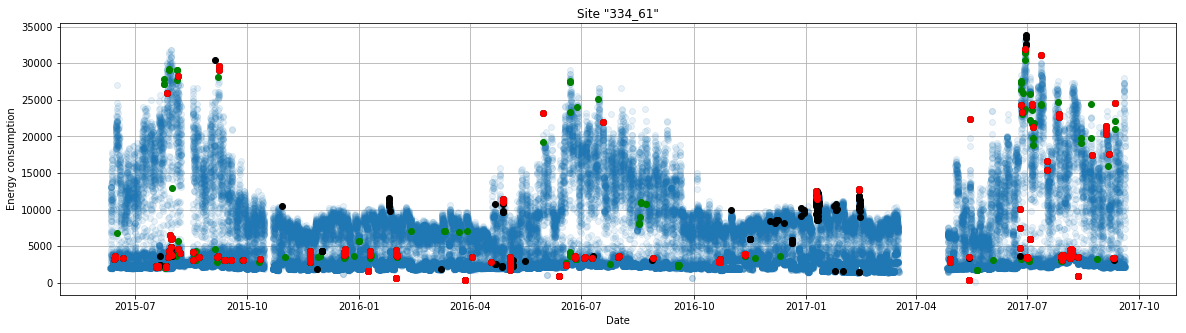

In [155]:
plt.figure(figsize=(20,5))
plt.plot(train['Timestamp'],train['Values'],'o',alpha = 0.1)
plt.plot(train[train['is_abnormal_1']==True]['Timestamp'],train[train['is_abnormal_1']==True]['Values'],
         'go')
plt.plot(train[train['is_abnormal_2']==True]['Timestamp'],train[train['is_abnormal_2']==True]['Values'],
         'ko')
plt.plot(train[train['is_abnormal']==True]['Timestamp'],train[train['is_abnormal']==True]['Values'],
         'ro')
plt.title('Site "334_61"')
plt.xlabel('Date')
plt.ylabel('Energy consumption')
plt.grid(True)
savefig(figures_path+'fig_6')

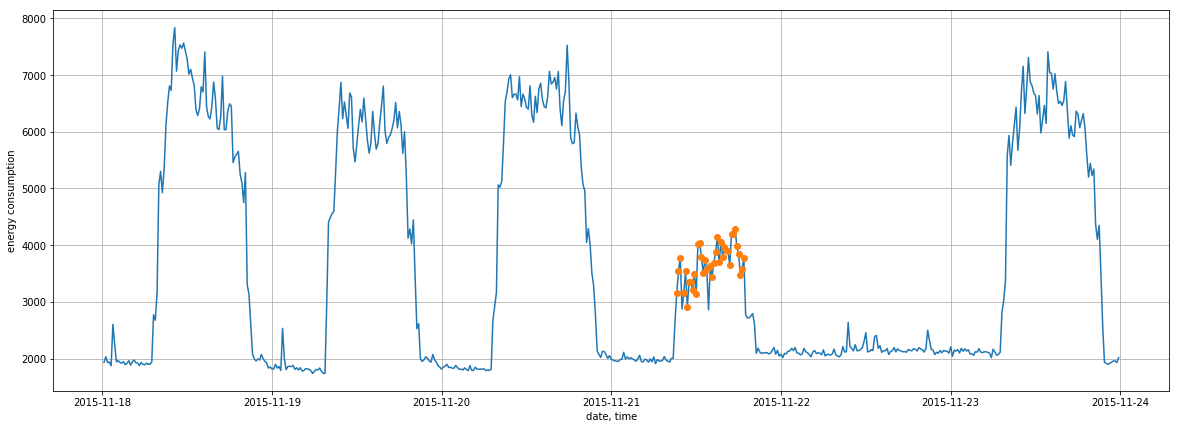

In [156]:
tmp = train[(train.Timestamp>'2015-11-18')&(train.Timestamp<'2015-11-24')]
plt.figure(figsize = (20,7))
plt.plot(tmp.Timestamp,tmp.Values)
plt.plot(tmp[tmp.is_abnormal == True].Timestamp,tmp[tmp.is_abnormal == True].Values,'o')
plt.grid(True)
plt.xlabel("date, time")
plt.ylabel("energy consumption")
savefig(figures_path+'fig_9')

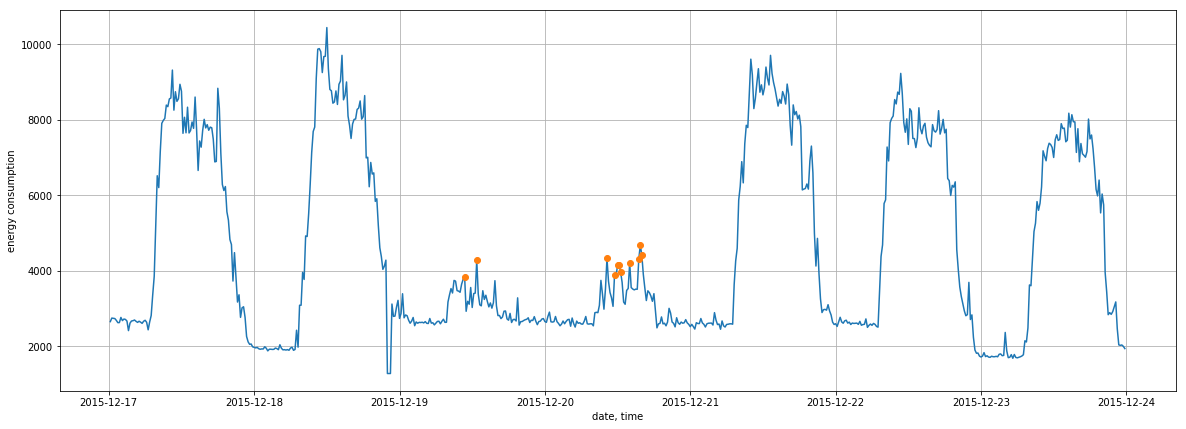

In [157]:
tmp = train[(train.Timestamp>'2015-12-17')&(train.Timestamp<'2015-12-24')]
plt.figure(figsize = (20,7))
plt.plot(tmp.Timestamp,tmp.Values)
plt.plot(tmp[tmp.is_abnormal == True].Timestamp,tmp[tmp.is_abnormal == True].Values,'o')
plt.grid(True)
plt.xlabel("date, time")
plt.ylabel("energy consumption")
savefig(figures_path+'fig_8')

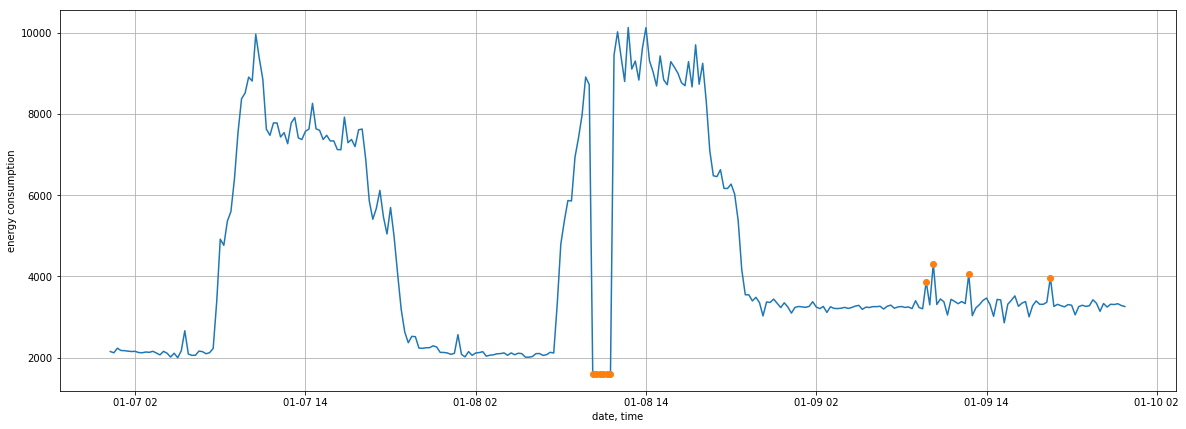

In [158]:
tmp = train[(train.Timestamp>'2016-01-07')&(train.Timestamp<'2016-01-10')]
plt.figure(figsize = (20,7))
plt.plot(tmp.Timestamp,tmp.Values)
plt.plot(tmp[tmp.is_abnormal == True].Timestamp,tmp[tmp.is_abnormal == True].Values,'o')
plt.grid(True)
plt.xlabel("date, time")
plt.ylabel("energy consumption")
savefig(figures_path+'fig_7a')

In [159]:
tmp = train[(train.Timestamp>'2017-05-14')&(train.Timestamp<'2017-05-16')]

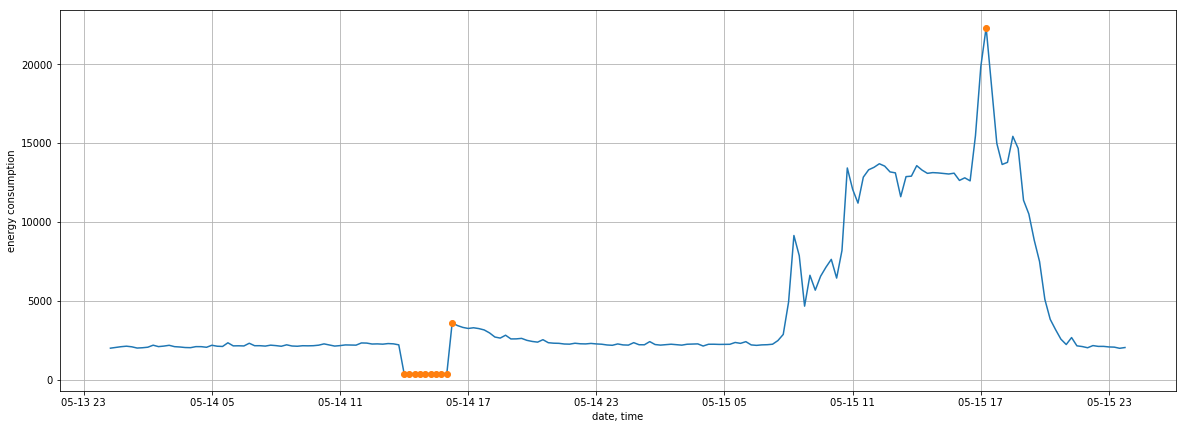

In [160]:
plt.figure(figsize = (20,7))
plt.plot(tmp.Timestamp,tmp.Values)
plt.plot(tmp[tmp.is_abnormal == True].Timestamp,tmp[tmp.is_abnormal == True].Values,'o')
plt.grid(True)
plt.xlabel("date, time")
plt.ylabel("energy consumption")
savefig(figures_path+'fig_7b')

In [161]:
with open(interim_path+'train_nn_knn_334_61.pkl', 'wb') as f:
    pickle.dump(train,f)


In [162]:
### You can check if you have the same number of labeled anomalies. For best submission I had 503 of anomalies here. 

train.is_abnormal.sum()

511